In [1]:
import h5py
import numpy as np
import nibabel.freesurfer.mghformat as mgh
import scipy.stats as stats

import sys
sys.path.append("..")
from paths import *
from constants import *

import matplotlib.pyplot as plt

In [2]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [10]:
subjid = ["01", "02", "03", "04", "05", "06", "07", "08"]
roi = "streams_shrink10"
hemi = "rh"
mapping_func = "PLS"
CV = 0
subsample = 2
model_name = "resnet18"
by_area = True

In [11]:
ROIs = ['Early',
         'Midventral',
         'Midlateral',
         'Midparietal',
         'Ventral',
         'Lateral',
         'Parietal']

In [12]:
if model_name == "alexnet":
    layer_keys = ALEXNET_LAYERS
elif model_name == "alexnet_torch":
    layer_keys = ALEXNET_TORCH_LAYERS
elif model_name == "vgg16":
    layer_keys = VGG16_LAYERS
elif model_name == "resnet18":
    layer_keys = RESNET18_LAYERS
elif model_name == "resnet50":
    layer_keys = RESNET50_LAYERS
elif model_name == "resnet101":
    layer_keys = RESNET101_LAYERS
elif model_name == "cornet-s":
    layer_keys = CORNETS_LAYERS
layer_keys = [
    item
    for sublist in [
        [item] if type(item) is not list else item for item in layer_keys
    ]
    for item in sublist
]

In [14]:
all_rs = np.zeros((len(subjid), len(ROIs), len(layer_keys)))
for sidx, sid in enumerate(subjid):
    
    # Get ROI data
    mgh_file = mgh.load(
        NSDDATA_PATH
        + "freesurfer/subj"
        + sid
        + "/label/"
        + hemi
        + "."
        + roi
        + ".mgz"
    )
    streams = mgh_file.get_fdata()[:, 0, 0]
    streams_trim = streams[streams != 0]
    num_vox = streams_trim.shape[0]
    
    if by_area:
        for r, area in enumerate(ROI_NAMES[1:]):
                # get model fits
                load_path = (RESULTS_PATH
                            + "fits_by_area/"
                            +"subj"
                            + sid
                            + "_"
                            + hemi
                            + "_"
                            + roi
                            + "_"
                            + area
                            + "_"
                            + model_name
                            + "_"
                            + mapping_func
                            + "_subsample_"
                            + str(subsample)
                            + "_"
                            + str(CV)
                            + "CV_1pretraining_fits.hdf5")
                fits = {}
                with h5py.File(load_path, "r") as f:
                    keys = f.keys()
                    for k in keys:
                        fits[k] = f[k][:]
                for lix, layer in enumerate(layer_keys):
                    all_rs[sidx][r][lix] = np.mean(fits[layer])
    else:
        load_path = (RESULTS_PATH 
                    + "fits/subj"
                    + sid
                    + "_"
                    + hemi
                    + "_"
                    + roi
                    + "_"
                    + model_name
                    + "_"
                    + mapping_func
                    + "_subsample_"
                    + str(subsample)
                    + "_"
                    + str(CV)
                    + "CV_fits.hdf5")
        fits = {}
        with h5py.File(load_path, "r") as f:
            keys = f.keys()
            for k in keys:
                fits[k] = f[k][:]

        for r in range(len(ROIs)):
            for lix, layer in enumerate(layer_keys):
                all_rs[sidx][r][lix] = np.mean(fits[layer][streams_trim==r+1])

In [15]:
mean_across_subjs = np.mean(all_rs, axis=0)

In [16]:
mean_across_subjs.shape

(7, 11)

<function matplotlib.pyplot.show(close=None, block=None)>

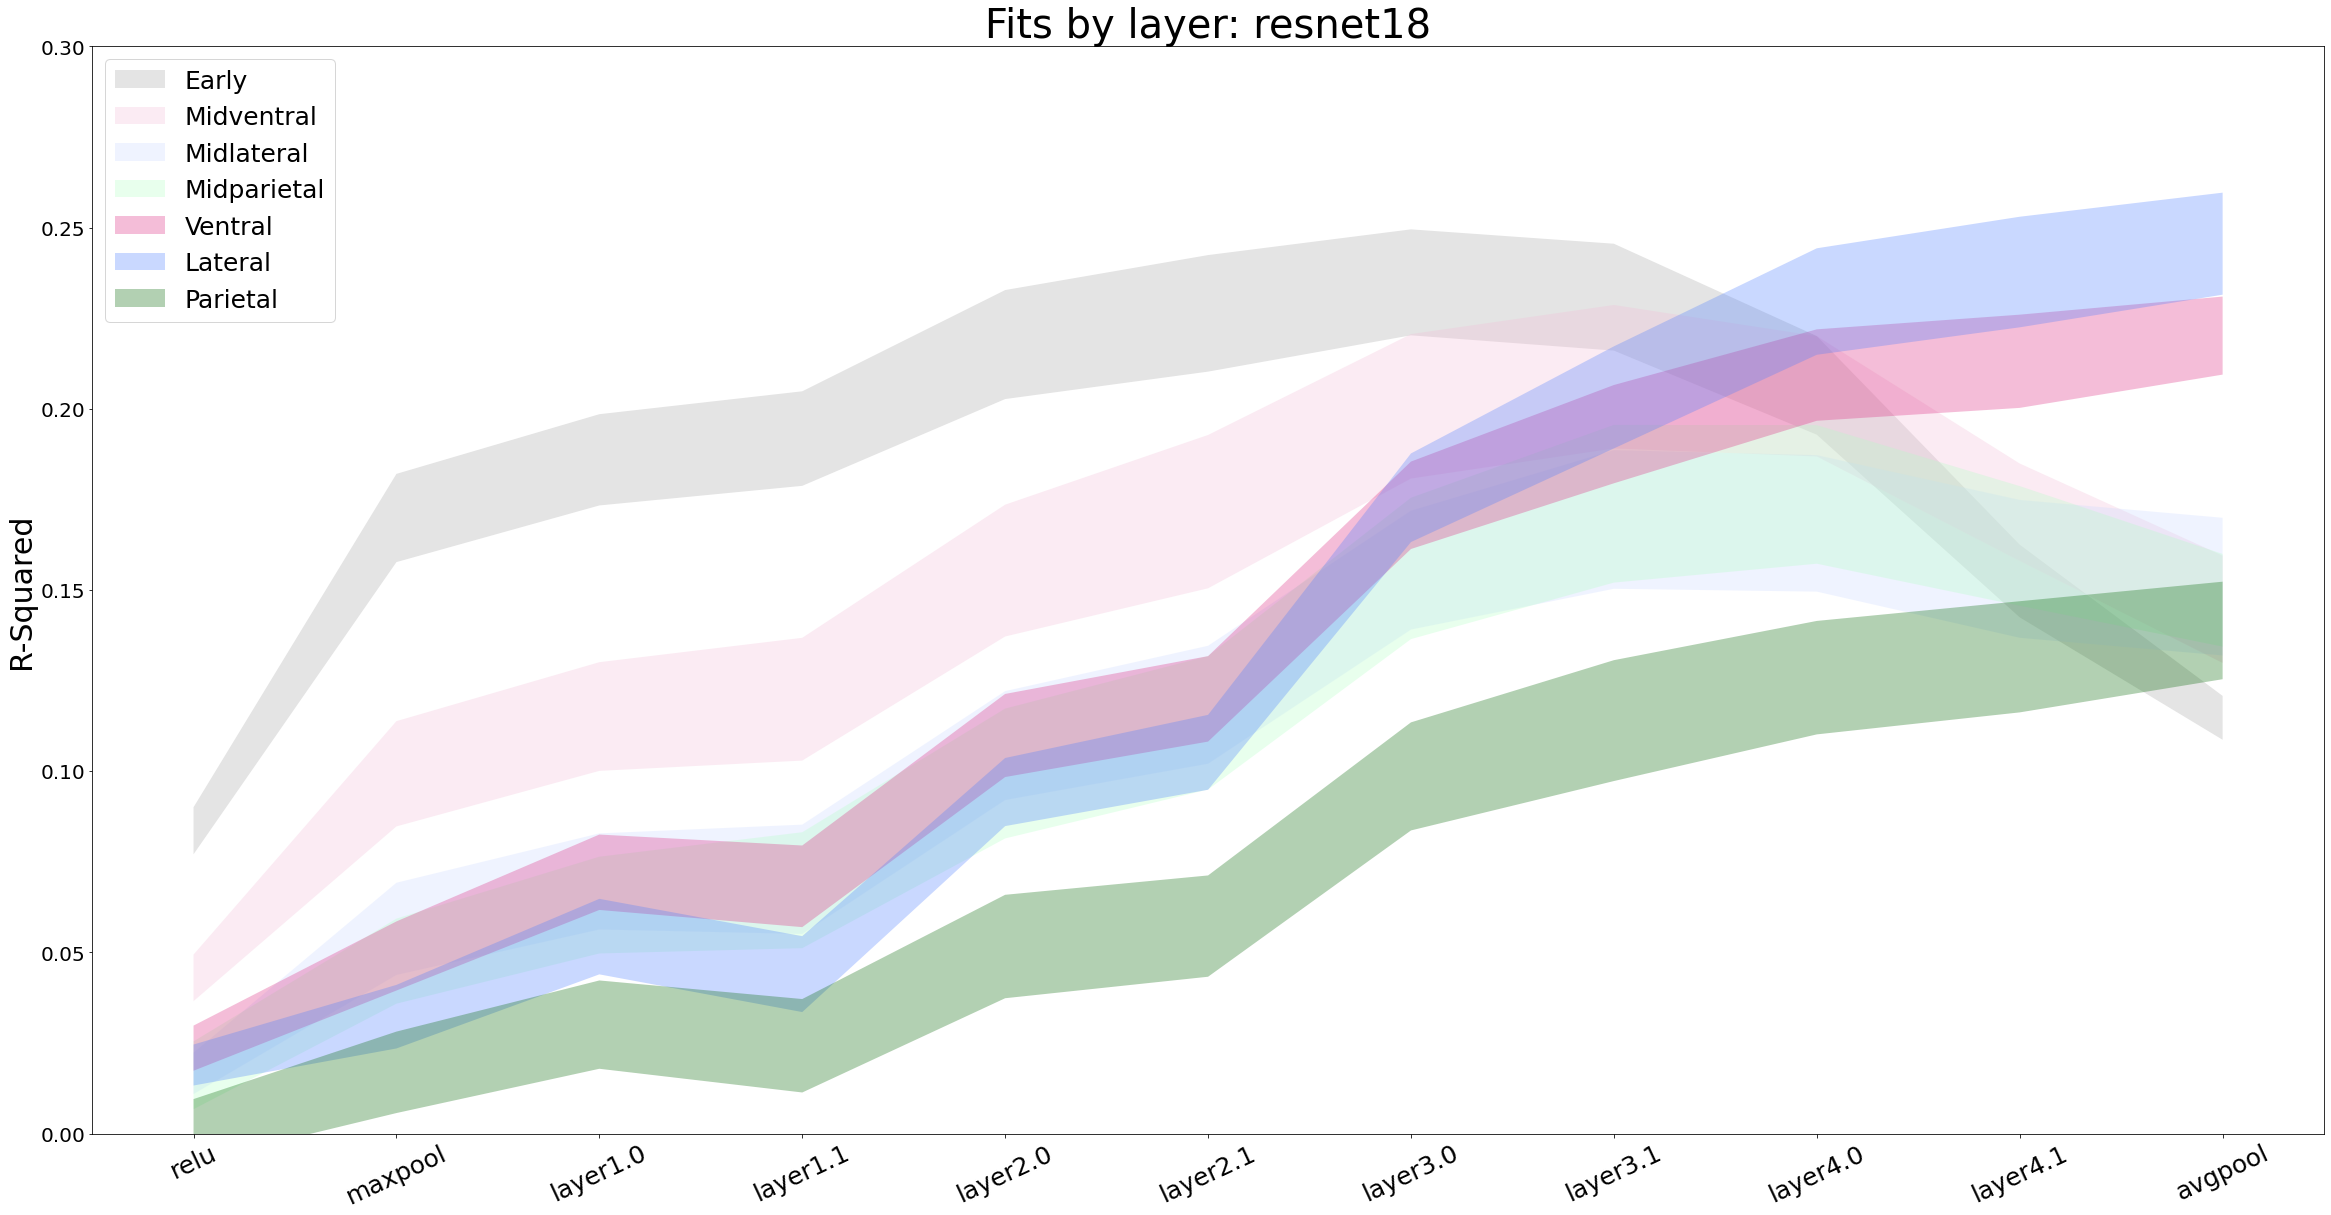

In [8]:
fig, ax = plt.subplots(figsize=(40, 20))
fig.patch.set_facecolor('white')

presets = ['#a6a6a6' , '#f4bdd8', '#ccdaff', '#b3ffc6',  '#DC267F' ,'#4d7fff','#006600']
x = range(0,len(layer_keys))
for rix, roi in enumerate(ROIs):
    y1 = mean_across_subjs[rix, :] + stats.sem(all_rs[:, rix, :], axis=0)
    y2 = mean_across_subjs[rix, :] - stats.sem(all_rs[:, rix, :], axis=0)
    plt.fill_between(x, y1, y2,
                 facecolor=presets[rix], # The fill color
                 alpha=0.3)          # Transparency of the fill
    #plt.plot(mean_across_subjs[rix, :], color=presets[rix])
plt.legend(labels=ROIs, fontsize=25, loc='upper left')

plt.xticks(range(0, len(layer_keys)), layer_keys, rotation=25, fontsize=25)

plt.ylabel('R-Squared',size = 30)
plt.yticks(fontsize=20)
plt.ylim(0, 0.3)

title_string = "Fits by layer: "
title_string += model_name
plt.title(title_string,size = 40)

save_path = (RESULTS_PATH 
                + "fits/figures/fits_by_layer_"
                + model_name
                + "_PCA.png")

#fig.savefig(save_path)
plt.show